[View in Colaboratory](https://colab.research.google.com/github/gmlander/Springboard/blob/master/Portfolio/Computer_Vision_With_Boosted_Augmentation/TTA_CNN_Boosting.ipynb)

# Beyond Average: TTA Ensembling through Neural Net Boosting

>[Beyond Average: TTA Ensembling through CNN Boosting](#scrollTo=N7WSaVUJhECr)

>[Predict and Create Submission](#scrollTo=6UdwY_SahEEV)

>>>[Imports, Utilities, and Authentications](#scrollTo=yJbveaHaq1HK)

>>>>[Connect to Google Drive](#scrollTo=xbUj24yJXZWj)

>>>>[Invite some modules](#scrollTo=phNWlWwtXejF)

>>>>[Steal Adapt functions from keras.preprocessing](#scrollTo=ZN5dQ-Q70D9b)

>>>>[Build Some Visualization Functions](#scrollTo=oFLyv-MyfgCc)

>>>>[Keep it classy](#scrollTo=B42ED6yFpRWM)

>>>>[TTA Workhorse Functions](#scrollTo=2RJ62uVwwIeC)

>>>>[Load Model and Dependencies](#scrollTo=4gp2Rwa3cgsR)

>>>[Examine Image Transformations](#scrollTo=YQW1PbF3VBuI)

>>[Applying TTA](#scrollTo=y7wno-9L1nBr)

>>>[Construct Data](#scrollTo=ImxgrXtKsWtK)

>>>[The problem with traditional TTA](#scrollTo=NnuYc8RlUId4)

>>>>[Set Baseline](#scrollTo=JMYDzeV5ODdb)

>>>[Work In Progress](#scrollTo=VhsJNrUEiJqA)

>>>>[Architecture - Theoretical Justification](#scrollTo=Fm0eE6G1_hcH)

>>>>[Architecture - Construction](#scrollTo=kWtgBb24aDXS)

>>>[Cool story but... does it work?](#scrollTo=md-Zx6axbGfV)



### Imports, Utilities, and Authentications

#### Connect to Google Drive

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# !fusermount -u drive
!mkdir -p drive
!google-drive-ocamlfuse drive

Install whatever modules may be needed

In [0]:
!pip install pydot
!pip install graphviz

    100% |████████████████████████████████| 133kB 3.6MB/s 
  Running setup.py bdist_wheel for pydot ... - done
  Stored in directory: /content/.cache/pip/wheels/6a/a5/14/25541ebcdeaf97a37b6d05c7ff15f5bd20f5e91b99d313e5b4
Successfully built pydot


#### Invite some modules

In [0]:
from __future__ import print_function
# from __future__ import absolute_import

import h5py, time, os, sys
import vis

if not os.path.isfile('clr_callback.py'):
  !wget https://raw.githubusercontent.com/bckenstler/CLR/master/clr_callback.py
from clr_callback import CyclicLR

from keras.models import load_model, Sequential, Model
from keras.utils import Sequence, np_utils
from keras import backend as K
from keras.optimizers import Adam
from keras.regularizers import l2, l1, l1_l2
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Flatten, InputLayer, Conv2D, LocallyConnected2D,\
                        MaxPooling2D, Input, Concatenate, GaussianNoise,\
                        Permute, BatchNormalization, Activation, Dense, Dropout,\
                        ActivityRegularization

from keras import activations
from keras.layers.advanced_activations import LeakyReLU

import tensorflow as tf

import pydot, graphviz
import numpy as np
import pandas as pd
import scipy.ndimage as ndi
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import cv2

import numpy as np
from numpy.random import permutation
import matplotlib.pyplot as plt
import cv2
import copy
import math
import pylab
import seaborn as sns
%matplotlib inline

os.chdir('drive/imMaterialist')

#### ~~Steal~~ Adapt functions from keras.preprocessing
> De-randomized, and default arg values changed

In [0]:
def elapsed(start):
    elapsed = time.time()-start
    hours, rem = divmod(elapsed, 3600)
    minutes, seconds = divmod(rem, 60)
    return("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

def static_zoom(x, zoom_range, row_axis=0, col_axis=1, channel_axis=2,
                fill_mode='constant', cval=0.):
    zx, zy = zoom_range
    zoom_matrix = np.array([[zx, 0, 0],
                            [0, zy, 0],
                            [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(zoom_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x

def static_shift(x, shift, row_axis=0, col_axis=1, channel_axis=2,
                 fill_mode='constant', cval=0.):
    hs, ws = shift
    h, w = x.shape[row_axis], x.shape[col_axis]
    tx = hs * h
    ty = ws * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])

    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x
  
def static_shear(x, intensity, row_axis=0, col_axis=1, channel_axis=2,
                 fill_mode='constant', cval=0.):
    shear = np.deg2rad(intensity)
    shear_matrix = np.array([[1, -np.sin(shear), 0],
                             [0, np.cos(shear), 0],
                             [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(shear_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x  

def static_rotation(x, rg, row_axis=0, col_axis=1, channel_axis=2,
                    fill_mode='constant', cval=0.):
    theta = np.deg2rad(rg)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])

    h, w = x.shape[row_axis], x.shape[col_axis]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(x, transform_matrix, channel_axis, fill_mode, cval)
    return x
  
def flip_horiz(x, dummy_arg = None):
    return np.fliplr(x)

def dummy_func(x, dummy_arg):
    return x
  
def apply_transform(x,
                    transform_matrix,
                    channel_axis=2,
                    fill_mode='constant',
                    cval=0.):
    x = np.moveaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=1,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x
  
def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix


#### Build Some Visualization Functions

In [0]:
def Occlusion_exp(model, image, label, occluding_size, occluding_pixel, occluding_stride):
    '''
    Adapted from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps
    and
    https://github.com/oswaldoludwig/Sensitivity-to-occlusion-Keras-/blob/master/occlusion_sensitivity.py
    '''
    
    im = image.astype(np.float32)
    im = np.expand_dims(im, axis=0)
    index_object = label - 1
    height, width, _ = image.shape
    output_height = int(math.ceil((height-occluding_size) / occluding_stride + 1))
    output_width = int(math.ceil((width-occluding_size) / occluding_stride + 1))
    heatmap = np.zeros((output_height, output_width))
    
    for h in range(output_height):
        for w in range(output_width):
            # Occluder region:
            h_start = h * occluding_stride
            w_start = w * occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)
            # Getting the image copy, applying the occluding window and classifying it again:
            input_image = copy.copy(image)
            input_image[h_start:h_end, w_start:w_end,:] =  occluding_pixel            
            im = input_image.astype(np.float32)
            im = np.expand_dims(im, axis=0)
            out = model.predict(im)
            out = out[0]
            prob = (out[index_object]) 
            heatmap[h,w] = prob
    
    return heatmap

# scale image by its training mean and std
def tr_scale(image):
    image = image.astype('float32', copy=False)
    image -= train_mean
    image /= train_std
    return image

# get img occlusion heatmaps
def get_occlusions(img, model, transforms, tvals, lbl, save_file = 'hm',
                   occluding_size = 25,
                   occluding_pixel = 0,
                   occluding_stride = 5):

    hm = [None]*len(transforms)

    for i, (func, val) in enumerate(zip(transforms, tvals)):
        tf_img = func(img,val)
        sc_tf_img = tr_scale(tf_img)
        hm[i] = Occlusion_exp(model, sc_tf_img,lbl, occluding_size,
                              occluding_pixel, occluding_stride)
    if save_file is not None:
        np.save(save_file + '.npy', np.array(hm))
    return hm

def show_transforms(rand_img, transforms, tvals, tf_labels):
    
    fig = plt.figure(figsize=(8, 8))
    for i, (func, val) in enumerate(zip(transforms, tvals)):  
        ax = plt.subplot(2,3,i+1)
        plt.imshow(func(rand_img,val))
        plt.subplots_adjust(wspace = 0.05, hspace = 0)
        ax.set_axis_off()
        ax.set_title(tf_labels[i])
    plt.show()

def show_occlusions(hm, tf_labels, cmap = None):
    
# colourmap from green to red, biased towards the blue end.
# Try out different gammas > 1.0
    cmap = cmap if cmap else colors.LinearSegmentedColormap.from_list('RdBu_r',['r','b'],gamma=10)
    p_max = np.amax(np.array(hm))
    p_min = np.amin(np.array(hm))
    fig = plt.figure(figsize=(10, 10))
    for i, hmap in enumerate(hm):  
        ax = plt.subplot(2,3,i+1)
        sns.heatmap(hmap,xticklabels=False, yticklabels=False, cmap=cmap,
                    vmax = p_max, vmin = p_min, ax = ax)
        ax.set_axis_off()
        ax.set_title(tf_labels[i])
    plt.show()

#### Keep it classy

In [0]:
class ThreadedModel:
    def __init__(self, model_path, train_mean = None, train_std = None,
                 weights = None, bs = 100, nasnet = False):
        'Loads model, then predicts on dummy data so keras can build GPU function'

        self.model = load_model(model_path)
        self.graph = tf.get_default_graph
        if weights:
            self.model.load_weights(weights)
        self.train_mean = train_mean
        self.train_std = train_std
        self.nasnet = nasnet
        self.bs = bs
        self.simple_scale = train_mean is None or train_std is None
        self.model.predict(np.zeros(shape=(self.bs,224,224,3),
                                    dtype=np.float32), batch_size=self.bs)
        self.session = K.get_session()
        self.graph = tf.get_default_graph()
        self.graph.finalize()

    def preproccesing(self, X):
        'Scale data conditionally'
        X = X.astype('float32', copy=False)
        if self.simple_scale:
            X /= 127.5
            X -= 1
        else:
            X -= self.train_mean
            X /= self.train_std
        return X

    def frozen_predict(self, data):
        'Runs predict method of model'
        X_scale = self.preproccesing(data)
        with self.session.as_default():
            with self.graph.as_default():
                if self.nasnet:
                    return self.model.predict(X_scale, batch_size = self.bs)[0]
                else:
                    return self.model.predict(X_scale, batch_size = self.bs)


#### TTA Workhorse Functions

In [0]:
def get_transform_preds(model_file,
                        weights = None,
                        data_file = 'imMaterialist/all_images.h5',
                        num_images = 6000,
                        batch_size = 100,
                        swap_classes = True,
                        train_mean = None, train_std = None,
                        img_offset = 0,
                        transforms = [dummy_func],
                        tr_vals = ['asdf'],
                        faster = False,
                        test_imgs = False,
                        nasnet = False,
                        verbose = 0):
    '''
    Predicts images on a frozen graph of given model over given transformations.
    Can handle multi-threading if num_threads > 1.
    Scales by training mean and std if provided, otherwise by keras default.
    
    Returns ndarray of class probabilities with dimensions:
        (num_images, num_transformations, num_classes, 1)
    '''
        
    full_start = time.time()
    predictions = [None]*len(transforms)
    
    ####################### USED FOR FOR FASTER VERSION ######################
    if faster:
        K.clear_session()
        xmodel = ThreadedModel(model_file,train_mean,train_std, bs = batch_size,
                               weights = weights, nasnet = nasnet)
    ##########################################################################

    with h5py.File(data_file, 'r') as hf:
        # Open connection to images
        if test_imgs:
            images = hf['test']['images'][img_offset:num_images]\
            .astype(np.uint8, copy = False)
        else:
            images = hf['test_dataset'][img_offset:num_images]\
            .astype(np.uint8, copy = False)
        
        if faster and verbose > 0:
            print('Loaded data and model in:', elapsed(full_start))
        data_start = time.time()

        
        # Predict on each batch of image transforms
        for j, transform in enumerate(transforms):

            pred_tr_start = time.time()
            
            ################### DONT USE FOR FASTER VERSION ################
            if not faster:
                K.clear_session()
                xmodel = ThreadedModel(model_file,train_mean,train_std,bs=batch_size,
                                       weights = weights, nasnet = nasnet)
                if verbose > 0:
                    if j == 0:
                        print('Loaded data and model in:', elapsed(full_start))
                    else:
                        print('Reloaded model in:', elapsed(pred_tr_start))
            ################################################################
            
            tr_images = np.array([transform(img,tr_vals[j]) for img in images])
            predictions[j] = xmodel.frozen_predict(data = tr_images)
            if not faster:
                del xmodel

            if verbose > 0:
                print('Predictions for transform number {} -- complete! Time: {}'\
                      .format(j+1, elapsed(pred_tr_start)))

    if verbose > 0:
        print('Total time:',elapsed(full_start))
    
    full_preds = [p.reshape(num_images - img_offset,1,128) for p in predictions]
    matrix_preds = np.concatenate(full_preds,1)
    if swap_classes:
        matrix_preds = matrix_preds[:, :, [127, *np.arange(1,127), 0]]
    matrix_preds = matrix_preds.reshape((*matrix_preds.shape,1))
    if faster:
        del xmodel
    return matrix_preds

def build_tta_model(pred_mat, dest, test_labels, dest_path = None,
                    tta_form = None, cyc_lr = None, verbose = 0):
    
    assert pred_mat.shape[0] == len(test_labels)
    if type(tta_form) == str: K.clear_session()
    dest = dest_path + dest if dest_path else dest
    
    # convert labels to one-hot encoded
    test_labels = np.reshape(test_labels, (len(test_labels), 1)).astype(np.uint8)
    test_labels -= 1
    test_labels = np_utils.to_categorical(test_labels, 128)

    # initialize callbacks
    model_checkpoint = ModelCheckpoint(dest, monitor = 'val_acc',
                                       save_best_only=True,
                                       mode = 'max',verbose = verbose > 1)
    early_stop = EarlyStopping(monitor = 'val_acc', mode = 'max', patience = 50)
    lr_reducer = ReduceLROnPlateau(monitor='val_acc', mode = 'max',
                                   factor = np.sqrt(0.5), patience = 10,
                                  min_lr = 1e-8)
    callbacks = [model_checkpoint, early_stop]
    callbacks += [cyc_lr] if cyc_lr else [lr_reducer]
    
    # build or load model
    if tta_form:
        model = load_model(tta_form) if type(tta_form) == str else tta_form
    else:    
        model = Sequential()
        model.add(InputLayer(input_shape=pred_mat.shape[1:]))
        model.add(Flatten())
        model.add(Dense(512, activation = 'relu'))
        model.add(Dropout(.8))
        model.add(Dense(128, activation = 'softmax'))

    model.compile(optimizer=Adam(lr = 1e-2),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(pred_mat, test_labels, batch_size = 1000, epochs = 1000,
                         callbacks = callbacks,
                         validation_split = .18, verbose = verbose > 1)
    if verbose > 0:
        print('Model has been trained and saved to {}.\nBest Val_acc: {}'.format(dest, model_checkpoint.best))
    return history

#### Load Model and Dependencies

In [0]:
train_mean = np.load('train_mean.npy')
train_std = np.load('train_std.npy')
model = load_model('xception_model.h5')

transforms = [dummy_func,flip_horiz, static_shift,
              static_rotation, static_shear, static_zoom]
tf_labels = ['Original','H-Flip', 'Shift','Rotate','Shear', 'Zoom']
tvals = ['_',0, (.2,.3), 30, 15, (.8,.8)]

I'm going to do a magic trick. I'm going to take two models that average 81% accuracy, and turn them into one model that is over 85% accurate. How you ask? Through TTA.

### What is TTA?

Image/Data Augmentation in computer vision, is the practice of using image transformations (flips, rotates, shifts, etc) to artificially inflate the size of a dataset, by pretending each image is dozens, hundreds, or even thousands of images (depending on the level of augmentation).

TTA, or Test-Time Augmentation,, is Image Augmentation's weird buddy who everybody's sort of run into, but nobody's really gotten to know. It's the same practice as regualr augmentation, but performed at inference / testing. The idea is that by predicting on multiple versions of the same image and averaging those predictions, the classifier can actually do a better job at predicting.

#### Examine Image Transformations

A few basic transformations of the same random image.

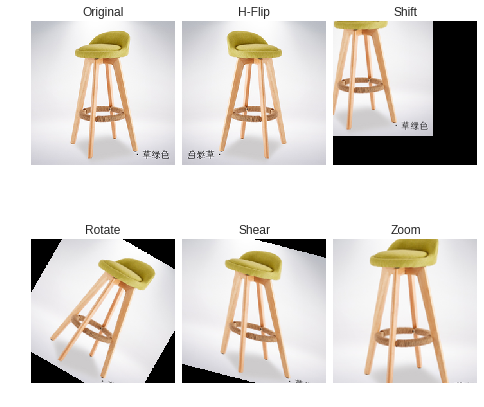

In [0]:
img_ix = np.random.randint(0, 1000) # img_ix was 555
with h5py.File('../iMaterialist/train_1.h5', 'r') as hf:
    rand_img = hf['train']['images'][img_ix]
    lbl = hf['train']['labels'][img_ix]
show_transforms(rand_img, transforms, tvals, tf_labels)

How does that work you might ask? Because by moving an image around, the model is getting to notice parts of the image it might not have otherwise seen. Image classifiers are made up of millions of parameters forming thousands of filters, where each filter learns to recognize a different pattern of pixels as a 'thing'. Imagine trying to translate French with a stadium full of people who each understand exactly 1 word of the language and nothing more, then the entire stadium trying to come to a consensus of what it heard. Not a pretty sight. A similar (but much more mathematically grounded) process occurs as activations from the input image move up through the layers of the network.

Rather than go into minute details on the workings of Convolutional Neural Networks, it might be better instead generate some image occlusions to give a sense of how a model 'sees'.

**Image Occlusion**

> *How Occlusion Works*:  
> An image is predicted by a model many, many times with a black patch moving across it with each iteration. The prediction probability of the target class is saved to an ndarray at coordinates of the occlusion. Low probability means the region occluded was very important and vice-versa.

![alt text](http://cs231n.github.io/assets/cnnvis/occlude.jpeg)

Method introduced by [Visualising and understanding Convolutional Neural networks by M. Zeiler et al](http://www.matthewzeiler.com/wp-content/uploads/2017/07/arxive2013.pdf).


---
$\quad$

**How Occlusion Effects Our Random Image**

Passing our stool through the occluder, we see the model only really cares about a few little pieces of the picture (these are the parts causing strong activations in the filters).

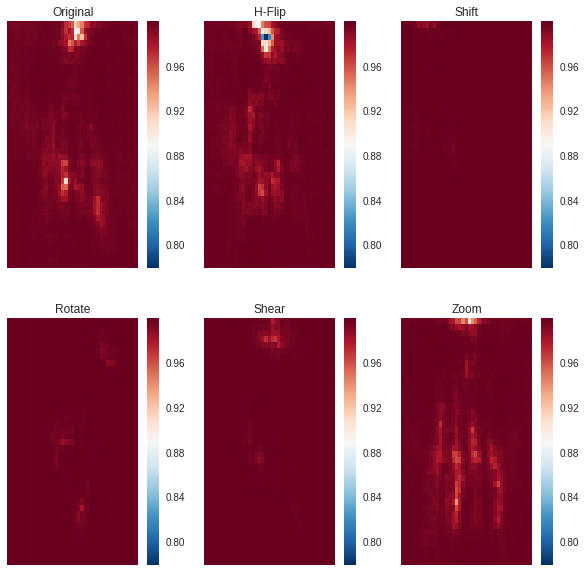

In [0]:
# this will take a few minutes depending on gpu
hm = get_occlusions(rand_img, model, transforms, tvals, lbl)
show_occlusions(hm, tf_labels,'RdBu_r')

Color maps can be tricky when you want to look at the differences of very small values. Below is the same heatmap with a custom color map with non-linear spacing to better emphasize the low values.

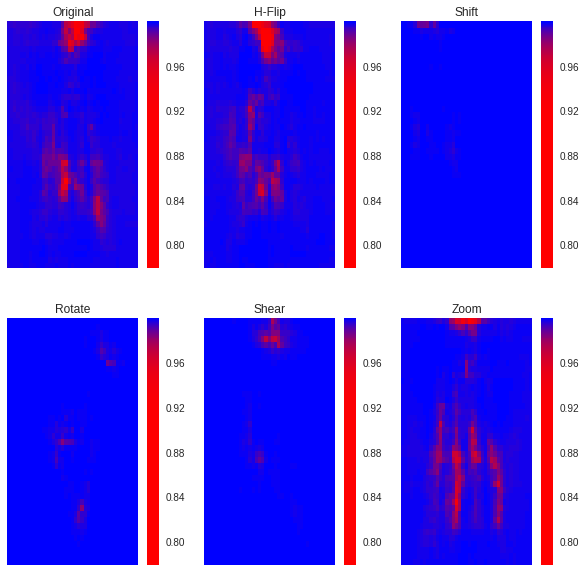

In [0]:
show_occlusions(hm, tf_labels)

The big takeaway from the occlusion is that the model appears to see different things more or less importantly dependent on how the image was transformed. This is what TTA takes advantage of to improve a model's accuracy without any additional training.

## Applying TTA

> *Sounds great! But umm... how do you do it?*

Ah. The problem with TTA. There's no consistent implementation. Some perform random transformations, some perform static. Some average, some weighted average. For this demonstration, I'm going to do static transforms for a reason that will soon become abundantly clear. To be specific, 14 transforms plus the original. It's all there in the code block below, but not necessary to read, only that little blurb on top.

### Construct Data

Generate predictions on fifteen image transformations to construct a matrix of probability vectors.

Goal is to have a matrix of shape (n_samples, n_pred_files, n_classes), so each element on first axis is an image, each row is prediction probabilities of original image and transforms, each column is class probability. So element i, j, k is the probability that image i after transform j belongs to class k.

In [0]:
transforms = [dummy_func, flip_horiz, *[static_shift]*4,
              *[static_rotation]*4, *[static_shear]*2, *[static_zoom]*3]
tr_vals = ['_',0, (.2,0.0), (0.0,.2),(-.2,0.0), (0.0,-.2), 20,-20,
           40, -40, 15, -15, (.8,.8), (.8,1.0), (1.0,.8)]

In [0]:
raw_preds = get_transform_preds(model_file='xception_model.h5',
                                data_file='all_images.h5',
                                test_imgs = True,
                                num_images=6000,
                                batch_size=100,
                                swap_classes=False,
                                train_mean=train_mean, train_std=train_std,
                                transforms=transforms,
                                tr_vals=tr_vals, verbose = 1, faster = True)

os.makedirs('predictions', exist_ok=True)
np.save('predictions/raw_test_preds.npy',raw_preds)

Loaded data and model in: 00:05:14.62
Predictions for transform number 1 -- complete! Time: 00:01:26.00
Predictions for transform number 2 -- complete! Time: 00:01:26.13
Predictions for transform number 3 -- complete! Time: 00:02:19.89
Predictions for transform number 4 -- complete! Time: 00:02:23.54
Predictions for transform number 5 -- complete! Time: 00:02:19.68
Predictions for transform number 6 -- complete! Time: 00:02:23.34
Predictions for transform number 7 -- complete! Time: 00:02:25.33
Predictions for transform number 8 -- complete! Time: 00:02:24.76
Predictions for transform number 9 -- complete! Time: 00:02:23.65
Predictions for transform number 10 -- complete! Time: 00:02:23.62
Predictions for transform number 11 -- complete! Time: 00:02:26.52
Predictions for transform number 12 -- complete! Time: 00:02:26.06
Predictions for transform number 13 -- complete! Time: 00:02:24.45
Predictions for transform number 14 -- complete! Time: 00:02:23.03
Predictions for transform number 

In [0]:
begin_eval = time.time()
for i, img_span in enumerate([(0,6000), (6000, 12801)]):
    print('Starting Round {}...'.format(i+1))
    eval_preds = get_transform_preds(model_file='xception_model.h5', 
                                    data_file='../iMaterialist/eval_dataset.h5',
                                    test_imgs = False,
                                    num_images=img_span[1],
                                    img_offset = img_span[0],
                                    batch_size=100,
                                    swap_classes=False, faster = True,
                                    train_mean=train_mean, train_std=train_std,
                                    transforms=transforms,
                                    tr_vals=tr_vals, verbose = 1,
                                    nasnet = False)

    os.makedirs('predictions', exist_ok=True)
    np.save('predictions/raw_eval_preds_{}.npy'.format(i+1),eval_preds)
print('Complete! Total time -- ', elapsed(begin_eval))

Starting Round 1...
Loaded data and model in: 00:01:17.01
Predictions for transform number 1 -- complete! Time: 00:01:25.86
Predictions for transform number 2 -- complete! Time: 00:01:26.14
Predictions for transform number 3 -- complete! Time: 00:02:15.74
Predictions for transform number 4 -- complete! Time: 00:02:18.83
Predictions for transform number 5 -- complete! Time: 00:02:15.20
Predictions for transform number 6 -- complete! Time: 00:02:16.86
Predictions for transform number 7 -- complete! Time: 00:02:19.06
Predictions for transform number 8 -- complete! Time: 00:02:18.91
Predictions for transform number 9 -- complete! Time: 00:02:16.85
Predictions for transform number 10 -- complete! Time: 00:02:17.76
Predictions for transform number 11 -- complete! Time: 00:02:19.30
Predictions for transform number 12 -- complete! Time: 00:02:23.63
Predictions for transform number 13 -- complete! Time: 00:02:27.04
Predictions for transform number 14 -- complete! Time: 00:02:22.64
Predictions f

Really Colab? You had to crash right there?
> *"You're making me look stupid. Get out here, panda jerk!"*"

In [0]:
# Once more, with feeling...
print('Starting Round {}...'.format(2))
eval_preds = get_transform_preds(model_file='xception_model.h5', 
                                data_file='../iMaterialist/eval_dataset.h5',
                                test_imgs = False,
                                num_images=12801,
                                img_offset = 6000,
                                batch_size=100,
                                swap_classes=False, faster = True,
                                train_mean=train_mean, train_std=train_std,
                                transforms=transforms,
                                tr_vals=tr_vals, verbose = 1,
                                nasnet = False)

os.makedirs('predictions', exist_ok=True)
np.save('predictions/raw_eval_preds_{}.npy'.format(2),eval_preds)

Starting Round 2...
Loaded data and model in: 00:01:26.88
Predictions for transform number 1 -- complete! Time: 00:01:37.05
Predictions for transform number 2 -- complete! Time: 00:01:37.03
Predictions for transform number 3 -- complete! Time: 00:02:32.98
Predictions for transform number 4 -- complete! Time: 00:02:36.36
Predictions for transform number 5 -- complete! Time: 00:02:30.83
Predictions for transform number 6 -- complete! Time: 00:02:33.94
Predictions for transform number 7 -- complete! Time: 00:02:35.66
Predictions for transform number 8 -- complete! Time: 00:02:35.82
Predictions for transform number 9 -- complete! Time: 00:02:36.34
Predictions for transform number 10 -- complete! Time: 00:02:35.23
Predictions for transform number 11 -- complete! Time: 00:02:36.36
Predictions for transform number 12 -- complete! Time: 00:02:34.92
Predictions for transform number 13 -- complete! Time: 00:02:37.59
Predictions for transform number 14 -- complete! Time: 00:02:37.47
Predictions f

**Get previously computed ndarrays**

In [0]:
test_preds = np.load('predictions/raw_test_preds.npy')
eval_preds = np.concatenate([np.load('predictions/raw_eval_preds_{}.npy'.format(i)) for i in [1,2]])

with h5py.File('all_images.h5', 'r') as hf:
    test_labels = hf['test']['labels'][:]

### The problem with traditional TTA

Everywhere I've seen TTA implemented, it's kind of in this form.

![tta](https://drive.google.com/uc?id=1lAkVy6hBB7c6KYm8J0ctIa4H3ZlWQH-s)

Everyone agrees that you get better accuracy by incorporating predictions of transformed images into your final prediction. But there doesn't seem to be a well established way of handling Step 2.

This is pulled straight from the fast.ai github.

---

**The fast.ai way**

>> ```
def TTA(self, n_aug=4, is_test=False):
        dl1 = self.data.test_dl     if is_test else self.data.val_dl
        dl2 = self.data.test_aug_dl if is_test else self.data.aug_dl
        preds1,targs = predict_with_targs(self.model, dl1)
        preds1 = [preds1]*math.ceil(n_aug/4)
        preds2 = [predict_with_targs(self.model, dl2)[0] for i in range(n_aug)]
        return np.stack(preds1+preds2).mean(0), targs
>>```

To their credit, fast.ai has been leading the charge on this technique and is way ahead of the curve, but all their method does is takes a weighted average of the prediction for each class where the original image is weighted between 20 and 50 percent of the total. The transforms performed are totally random (within the set of originally provided transforms to the fastai dataset object the model was constructed with).

Other interprettations on kaggle competitions had similar implementations. Some used static transforms, but all determined the final outcome by weighted average and then an argmax on the resulting array.

**The problem with Argmax**

It's not telling the whole story of the model's predictions, only the loudest voice. Even if maybe there's something to what the other class predictions are saying, they got thrown by the wayside.

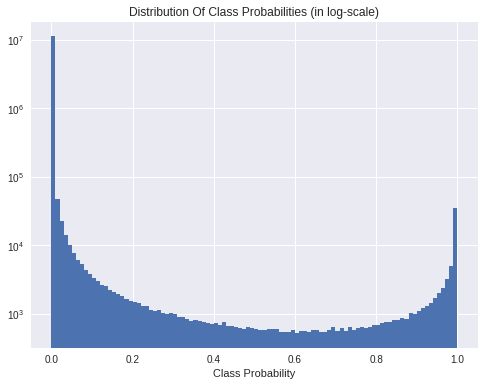

In [0]:
plt.figure(figsize=(8,6))
plt.hist(test_preds.flatten(), bins = 100, log = True)
plt.xlabel('Class Probability')
plt.title('Distribution Of Class Probabilities (in log-scale)')
plt.show()

Of course, the softmax activation on top of the network forces the probabilities towards 0 or 1, but there's still some ambiguity that's being thrown away. It was clear with the occlusions that noticable differences in predictions could occur with transformations.

Wouldn't it be great if rather than just averaging, we could apply ML to get a smarter algorithm for predicting final probabilities from these transforms? If only there was something really well suited to handling multidimensional inputs and capturing interaction effects...

**Another Neural Network!**

Yup, it's almost perfectly suited to this task and yet no one seems to be doing it.  Look at how the simplest of neural nets ---- input layer -->  single hidden dense layer --> a dropout layer --> a softmax activation ----- is able to improve the accuracy of a model.


In [0]:
from sklearn.metrics import accuracy_score
pred_y = test_preds[:,0,:,:].squeeze().argmax(1) + 1
print('Accuracy of the initial model predictions: {0:.2f}%'.format(100*accuracy_score(test_labels, pred_y)))

Accuracy of the initial model predictions: 79.60%


In [0]:
simple_hist = build_tta_model(test_preds, 'simple_tta.h5', test_labels, verbose = 1)

Model has been trained and saved to simple_tta.h5.
Best Val_acc: 0.8425925815546954


Without breaking a sweat, NN-Boosted TTA gains ~4.8 % accuracy. For a model that was converging around 79% accuracy on 128 classes, that's an insane amount of improvement.

And this is with a 'training'\* set this is a validation set of only 1k images, look how quickly  the model quickly overfit, finding it's best validation accuracy in the initial epochs. Imagine how much better this might do with a larger training set, or as a way of smartly ensembling multiple models together. The possiblities abound.

\*The real training set was used on the model and is inadmissible, so this is the validation set being used to train this TTA network.

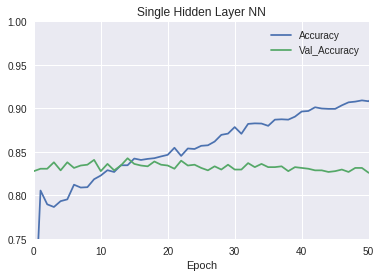

In [0]:
plt.plot(simple_hist.epoch,simple_hist.history['acc'], label = 'Accuracy')
plt.plot(simple_hist.epoch,simple_hist.history['val_acc'], label = 'Val_Accuracy')
plt.xlabel('Epoch')
plt.title('Single Hidden Layer NN')
plt.xlim((0,50))
plt.ylim((.75, 1))
plt.legend()
plt.gcf().savefig('TTA_simpleNN.png')
plt.show()

### Take it up to 11 with a CNN boost

**How to get better results?**  

The baseline results are encouraging. But we can do better!

...hopefully.

$\quad$ But how? We could add more layers (and we *will* add more layers), but what kind of layers? Consider the input shape, each image is represented by a 2d array where rows are different manipulations of the image and columns are classes. There are patterns in each dimension that need to be captured. If we were able to capture patterns with 2d convolutions on the original image, who's to say we can't capture patterns in these probability vectors the same way?

$\quad$ No one. No one is to say that. But... there's a distinct difference here. Even though I believe these probabilities have correlations and interactions, most of them are not based on spatial proximity in feature order the way they are in an image. Some adjacent features (different rotations and shifts) likely show these patterns, as they were different intensities of the same manipulation and are adjecent rows in the probability matrix, but for many others, this is not the case. 2d convolutions don't seem suited. 1d convolutions on the other hand, capable of looking through row by row or column by column probability vectors, make a lot of sense. We want the network to learn if there are patterns in class probabilities for a manipulated image under the assumption that $P(C_i|\ P(C_j)) \neq P(C_i)$ and more generally $ P(C_i|\ P(C_0,...,C_{i\text{-}1},C_{i+1},...,C_n)) \neq P(C_i)$.

$\quad$ 

$\quad$ **But** these effects exist in each direction. Not only are the class probabilities within a row not independent, but I suspect the probability of at least some classes have interaction effects and correlation with image manipulations. $P(M_{C_i}|\ P(M_{C_j})) \neq P(M_{C_i})$. What to do? A 1d convolution will sacrifice one of these sets of patterns. A 2d convolution will capture them, but it will also pick up on a lot of noise and vastly raise the parameter count.

$\quad$ Solution -- Parallel 1d convolutions. Each set of convolutions gets to look at the input before being pooled separately, then merged, then fed into dense layers before final activation.

**Note:** 
When I said 1d convolutions, I was ~~lying~~ simplifying. Because the keras layers typically expect multi-channel image data, it'll make building convolutions and understanding expected pooling inputs a lot easier if instead of inputting matrices of probabilities, we input single channel matrices. Basically, add a dummy dimension and do 2d convolutions with kernal dimensions ($n_{rows}$, 1) and (1, $n_{cols}$).

#### Architecture - Theoretical Justification

**Gaussian Noise**
>$\quad$ 5k samples is a very small amount to train a network on (1k used for validation). Overfitting is a major concern. One way to be proactive about this is with adding noise to the initial input. Don't want to add values outside range or usual inputs. Since it's probability input, no value is less than 0 or greater than 1. But noise can't be controlled that was as desired (at least not without adding a seperate generator class that will do so as a preprocessing step).

>$\quad$ Instead the layer only allows a stddev argument. Since 99% of observations are within 3 $\sigma$, of $\mu$ and $\mu = 0$ this means should give a stddev argument of about $\frac{1}{4}$ the largest magnitude value we'd ever want to allow added.

Let's check the mean and stddev of the probability values (we already saw the distribution):

In [0]:
print('Mean: {:0.6f}, \tStandard Deviation: {:0.6f}'.format(np.mean(test_preds.flatten()),np.std(test_preds.flatten())))

Mean: 0.007812, 	Standard Deviation: 0.078011


$\quad$ As should probably be expected because these were all outputs of a softmax activation function, most of the values are either very small or very large. This confirms the reason for this brief EDA on the noise layer input. Adding too much noise to training data would completely ruin the network for evaluating real probability vectors. Most of the values are less than 0.01, and much less at that. Since the largest magnitude we'd ever want to see added is .01 (1% probability),we'll give .0025 as the stddev argument.

---

**Convolutions**:

$\quad$ As previously described, we'll be doing 1d convolutions on the rows and columns in parallel. More specifically,it will be two different types of convolutions, standard and locally connected. The standard convolutions will pick up on row and column wise patterns applicable to all classes and manipulations. The locally connected convolutions will discover call and manipulation specific patterns. Locally connected layers typically don't have much value in image recognition, because it's kind of pointless to learn a pattern for pixels i:i+x, j:j+y as the slightest shift, rotation, or zoom in the picture nullifies the filter. In our case though, the same 'pixels' are always in the same position. $row_i$, $col_j$ will always be the $i^{th}$ manpulation and the $j^{th}$ class, so learning these local filters makes a lot of sense.

---

**Pooling**

$\quad$ Because these layers are going to have different output dimensions, and eventually need to be reconnected, some pooling layers need to do the job of downsampling. Normally pooling is effective because the activations of nearby kernels are closely related in each filter. This however is not the case with the type of filters being created. Instead of pooling filter by filter, it would be more meaningful to pool the same location **across** filters. So a **Permute** layer is added between the convolutions and pools. For now, I'm going to avoid pooling the LC-Convolution layers, since I'm not totally positive how a permute will affect those dimensions and I don't want to destroy the class-specific and manipulation-specific interactions I'm trying to capture. If they become a computational bottleneck, or source of overfitting, I'll reconsider.

#### Architecture - Construction
> *If you build it, he will come...*

In [0]:
# takes the probability matrices
input_layer = Input(shape=(test_preds.shape[1:]))

# add gaussian noise to inputs, feeds into each conv layer
noise_layer = GaussianNoise(stddev = 0.005)(input_layer)

# add Dense layer reading directly from original (noisy) inputs
flat_noise = Flatten()(noise_layer)
flat_noise = Dense(512)(flat_noise)
flat_noise = Activation('relu')(flat_noise)
flat_noise = Dropout(.9)(flat_noise)


# Manipulation convolutions -- 40 filters moving along the 15 different image probability vectors
path_2 = Conv2D(40, kernel_size = (1, 128), strides=1, name = 'manip_conv')(input_layer)
path_2 = BatchNormalization()(path_2)
path_2 = LeakyReLU()(path_2))
path_2 = Flatten()(path_2)
path_2 = Dense(256, activation = 'relu')(path_2)


# Class specific convolutions
path_3 = LocallyConnected2D(20, kernel_size = (30,1), strides=1, name = 'class_lc_conv')(input_layer)
path_3 = BatchNormalization()(path_3)
path_3 = LeakyReLU()(path_3)
path_3 = Flatten()(path_3)
path_3 = Dense(256, activation = 'relu')(path_3)


# Unite all 3 paths together, feed into dense layer then output layer
merged_layers = Concatenate(axis=1)([path_3, path_2, flat_noise])
merged_layers = Dense(1024, activation = 'relu')(merged_layers)
merged_layers = Dropout(.8)(merged_layers)
merged_layers = Dense(128, activation = 'softmax')(merged_layers)

pmodel = Model(inputs = input_layer, outputs = merged_layers)

# plot_model(pmodel, to_file='parallel_model.png')

### Cool story but... does it work?

>  I sure hope so. Let's find out!

In [0]:
test_preds_nas = np.load('predictions/raw_test_preds_nas82.npy')
pred_y = test_preds_nas[:,0,:,:].squeeze().argmax(1) + 1
print('Accuracy of the initial model predictions: {0:.2f}%'.format(100*accuracy_score(test_labels, pred_y)))

Accuracy of the initial model predictions: 81.40%


In [0]:
test_preds = np.concatenate([test_preds, test_preds_nas],1)

In [0]:
simple_hist = build_tta_model(test_preds, 'simple_tta_xnas.h5',test_labels,verbose = 2)

Train on 4920 samples, validate on 1080 samples
Epoch 1/1000
4920/4920 [==============================] - 0s 97us/step - loss: 4.8875 - acc: 0.0073 - val_loss: 3.2079 - val_acc: 0.8444

Epoch 00001: val_acc improved from -inf to 0.84444, saving model to simple_tta_xnas.h5
Epoch 2/1000
4920/4920 [==============================] - 0s 27us/step - loss: 3.2516 - acc: 0.8222 - val_loss: 1.4625 - val_acc: 0.8454

Epoch 00002: val_acc improved from 0.84444 to 0.84537, saving model to simple_tta_xnas.h5
Epoch 3/1000
4920/4920 [==============================] - 0s 19us/step - loss: 1.6304 - acc: 0.8313 - val_loss: 0.7805 - val_acc: 0.8426

Epoch 00003: val_acc did not improve from 0.84537
Epoch 4/1000
4920/4920 [==============================] - 0s 18us/step - loss: 0.8821 - acc: 0.8392 - val_loss: 0.7804 - val_acc: 0.8454

Epoch 00004: val_acc did not improve from 0.84537
Epoch 5/1000
4920/4920 [==============================] - 0s 18us/step - loss: 0.7922 - acc: 0.8415 - val_loss: 0.8509 - va


Epoch 00022: val_acc did not improve from 0.85648
Epoch 23/1000
4920/4920 [==============================] - 0s 18us/step - loss: 0.5031 - acc: 0.8730 - val_loss: 0.9585 - val_acc: 0.8546

Epoch 00023: val_acc did not improve from 0.85648
Epoch 24/1000
4920/4920 [==============================] - 0s 19us/step - loss: 0.4786 - acc: 0.8756 - val_loss: 0.9510 - val_acc: 0.8528

Epoch 00024: val_acc did not improve from 0.85648
Epoch 25/1000
4920/4920 [==============================] - 0s 18us/step - loss: 0.4938 - acc: 0.8697 - val_loss: 0.9434 - val_acc: 0.8546

Epoch 00025: val_acc did not improve from 0.85648
Epoch 26/1000
4920/4920 [==============================] - 0s 18us/step - loss: 0.4667 - acc: 0.8770 - val_loss: 0.9373 - val_acc: 0.8519

Epoch 00026: val_acc did not improve from 0.85648
Epoch 27/1000
4920/4920 [==============================] - 0s 19us/step - loss: 0.4812 - acc: 0.8730 - val_loss: 0.9330 - val_acc: 0.8519

Epoch 00027: val_acc did not improve from 0.85648
Epoc